In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import corner
import copy
import pickle
from astropy.io import ascii
from itertools import cycle
import math

import matplotlib.gridspec as gridspec

%matplotlib inline

# Plotting code

In [2]:
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.facecolor']='white'
mpl.rcParams['axes.edgecolor']='k'
mpl.rcParams['axes.linewidth']=3
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.color'] = 'k'
#mpl.rcParams['xtick.major.width'] = 2
#mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.color']='k'
mpl.rcParams['ytick.color']='k'
mpl.rcParams['axes.labelcolor']='k'

mpl.rcParams['font.size']=12
mpl.rcParams['xtick.direction']='in'
mpl.rcParams['ytick.direction']='in'
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5


def makeCmap(hexColour,zeroColour='#FFFFFF'):
    r0,g0,b0=mpl.colors.hex2color(zeroColour)
    r,g,b=mpl.colors.hex2color(hexColour)
    cdict = {'red':   ((0.0, r0, r0),
                   (1.0, r, r)),
         'green': ((0.0, g0, g0),
                   (1.0, g, g)),
         'blue':  ((0.0, b0, b0),
                   (1.0, b, b))
        }
    cmap = mpl.colors.LinearSegmentedColormap(hexColour,cdict)
    return cmap


def makeGradient(hexColour):
    r,g,b=mpl.colors.hex2color(hexColour)
    cdict = {'red':   ((0.0, r, r),
                   (1.0, r, r)),
         'green': ((0.0, g, g),
                   (1.0, g, g)),
         'blue':  ((0.0, b, b),
                   (1.0, b, b)),
         'alpha':  ((0.0, 0.0, 0.0),
                   (1.0, 1.0, 1.0))
        }
    cmap = mpl.colors.LinearSegmentedColormap(hexColour,cdict)
    return cmap


def makePlotColours(mappableList,coloursList):
    """
    mappableArray = a list of discrete values, each corresponding to a unique color (zero-indexed)
    coloursList = list of desired colors. Ideally should be at least as many colours as there are unique
                  entries in mappableArray.
    """
    
    zidx = []
    uniqueMappableList = np.unique(mappableList)
    for j in range(len(mappableList)):
        for i,entry in enumerate(uniqueMappableList):
            if mappableList[j] == entry:
                zidx.append(i)
    
    zidx = np.array((zidx))
    uniqueVals = len(np.unique(zidx))
    
    cidx = 0
    colourMaps = []
    cycledColours = []
    for c in cycle(coloursList):
        colourMaps.append(makeGradient(c))
        cycledColours.append(c)
        cidx+=1
        if cidx >= uniqueVals: 
            break
    
    blankCmap=makeGradient('#FFFFFF')
    colours = blankCmap(0.999*np.ones_like(zidx))

    for j in range(0,uniqueVals):
        colours[zidx==j] = colourMaps[j](0.999*np.ones_like(np.arange(0,len(zidx))[zidx==j]))

    return colourMaps,colours,cycledColours,list(uniqueMappableList)

In [3]:
def makePlot(ax, xdata, ydata, colours, xlabel, ylabel, sizes=100,
             legendTitle=None,legendEntries=None, legendColours=None,
             xlim=[], ylim=[],xscale="linear",yscale="linear",alpha=1):
    ax.scatter(xdata,ydata,c=colours,s=sizes,alpha=alpha)
    #ax.hexbin(xdata,ydata,cmap='Blues')
    nonans = (np.isfinite(xdata) & np.isfinite(ydata))
    xdata=xdata[nonans]
    ydata=ydata[nonans]
    colours=colours[nonans]
    
    xmin = np.min(xdata[xdata > 0.])#.value
    xmax = np.max(xdata)#.value
    
    ymin = np.min(ydata[ydata > 0.])#.value
    ymax = np.max(ydata)#.value

    if not xlim:
        if xscale=="log":
            ax.set_xlim(0.1*xmin,10.*xmax)
        else:
            ax.set_xlim(0.95*xmin,1.05*xmax)
    else:
        ax.set_xlim(xlim)
        
    if not ylim:
        if yscale=="log":
            ax.set_ylim(0.1*ymin,10.*ymax)
        else:
            ax.set_ylim(0.95*ymin,1.05*ymax)
    else:
        ax.set_ylim(ylim)
    
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    
    ax.set_xlabel(xlabel,fontsize=24)
    ax.set_ylabel(ylabel,fontsize=24)
    ax.tick_params(labelsize=18)
    
    if legendEntries is not None:
        if xscale=="log":
            minx = 1.e-7*xmin
        else:
            minx = -1000+(-1000*xmin)
                
        if yscale=="log":
            miny = 1.e-7*ymin
        else:
            miny = -1000+(-1000*ymin)
            
        for i in range(0,len(legendEntries)):
            ax.scatter([minx,minx],[miny,miny],s=200,c=legendColours[i],edgecolors=legendColours[i],label='{0}'.format(legendEntries[i]))
        leg=ax.legend(loc=0,ncol=1,frameon=False,fontsize=15,title=legendTitle)
        leg.get_title().set_fontsize('22')
    return 

# Planet data in usable format
## each planet object includes: [Teff, logg, [Fe/H], Rp/R*, P]

In [6]:
experimentName = "Rp_uniformP"
n_planet_features = 2

-2.07657076613
2.99585834636


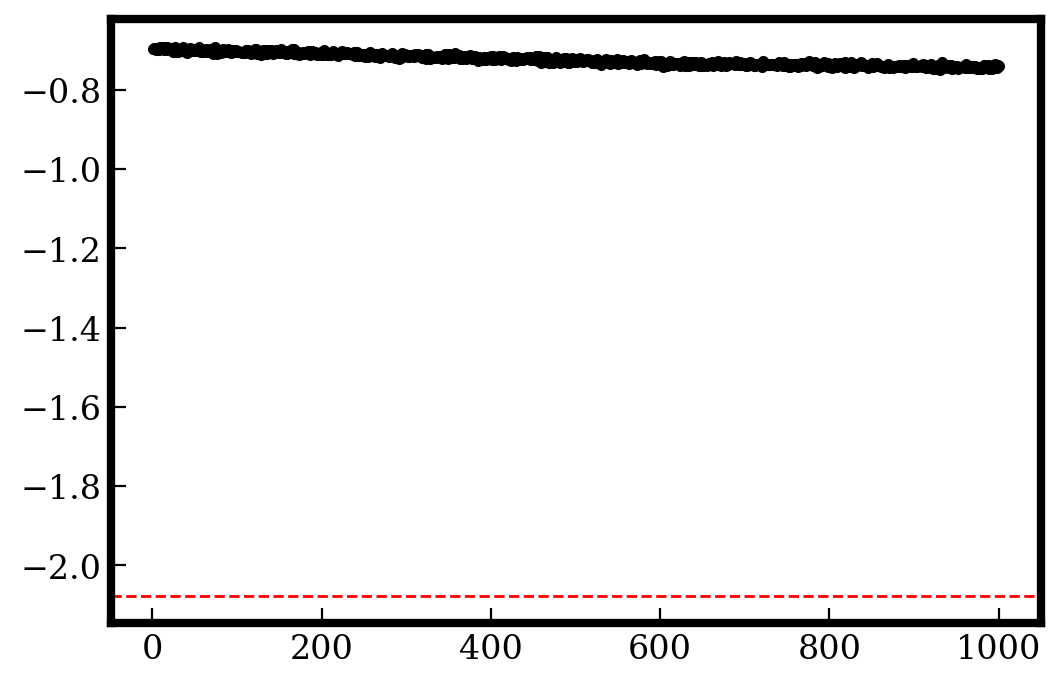

In [7]:
results = np.load("./simulatedPlanets/fake_grammaticalSystems_{0}_classprobs.npy".format(experimentName))
idxs = np.load("./simulatedPlanets/fake_grammaticalSystems_{0}_idxs.npy".format(experimentName))
losses = np.load("./simulatedPlanets/fake_grammaticalSystems_{0}_losses.npy".format(experimentName))

optimalLoss = float(np.load("./simulatedPlanets/fake_grammaticalSystems_{0}_optimalLoss.npy".format(experimentName)))
print(optimalLoss)
bits = -1*optimalLoss*math.log(math.e,2)
print(bits)
plt.plot(losses[:,0],losses[:,1],'k.')
plt.axhline(y=optimalLoss,color='r',ls="--",lw=1)
plt.show()

[[1.00000000e+00 1.15760928e-18 1.15760928e-18]
 [1.00000000e+00 6.09910199e-19 6.09910199e-19]
 [9.91925020e-34 1.00000000e+00 1.54069035e-10]
 ...
 [1.00000000e+00 8.69006421e-18 8.69006421e-18]
 [1.00000000e+00 2.15281929e-20 2.15281929e-20]
 [5.74431134e-08 5.35363085e-07 9.99999404e-01]]
[[1.00000000e+00 1.15760928e-18 1.15760928e-18]
 [1.00000000e+00 6.09910199e-19 6.09910199e-19]
 [9.91925020e-34 1.00000000e+00 1.54069035e-10]
 ...
 [1.00000000e+00 8.69006421e-18 8.69006421e-18]
 [1.00000000e+00 2.15281929e-20 2.15281929e-20]
 [5.74431134e-08 5.35363085e-07 9.99999404e-01]]


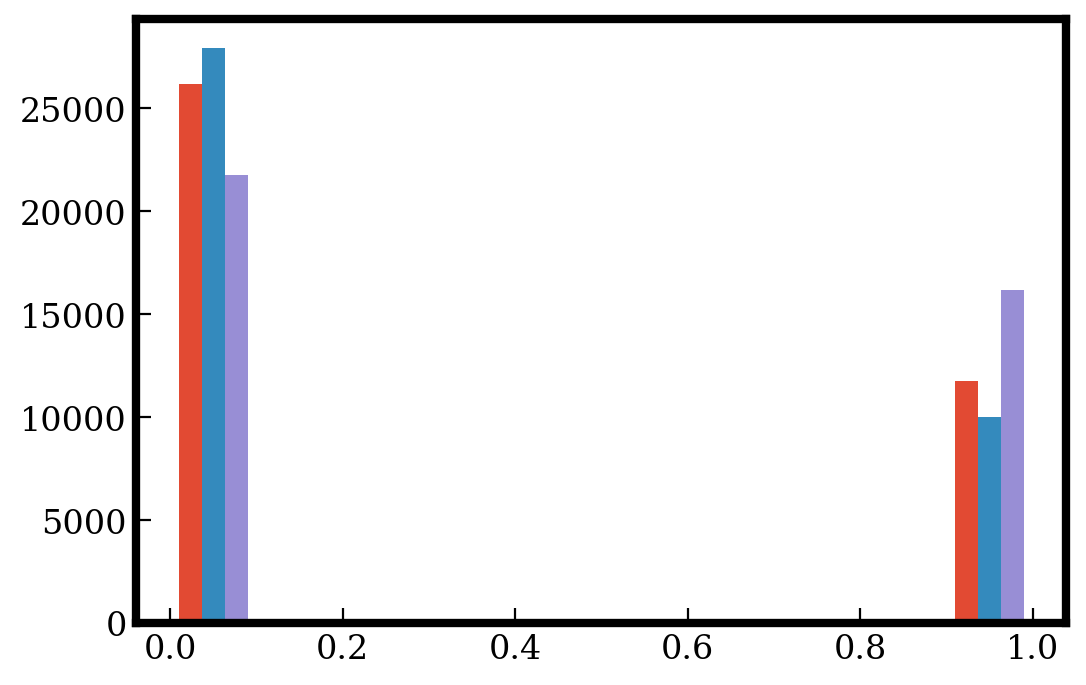

In [8]:
print(results)
print(results)

plt.hist(results)
plt.show()

(37932, 2)
[0 0 1 ... 0 0 2]
(37932,)
(37932,)
[0. 0. 2. ... 0. 0. 1.]


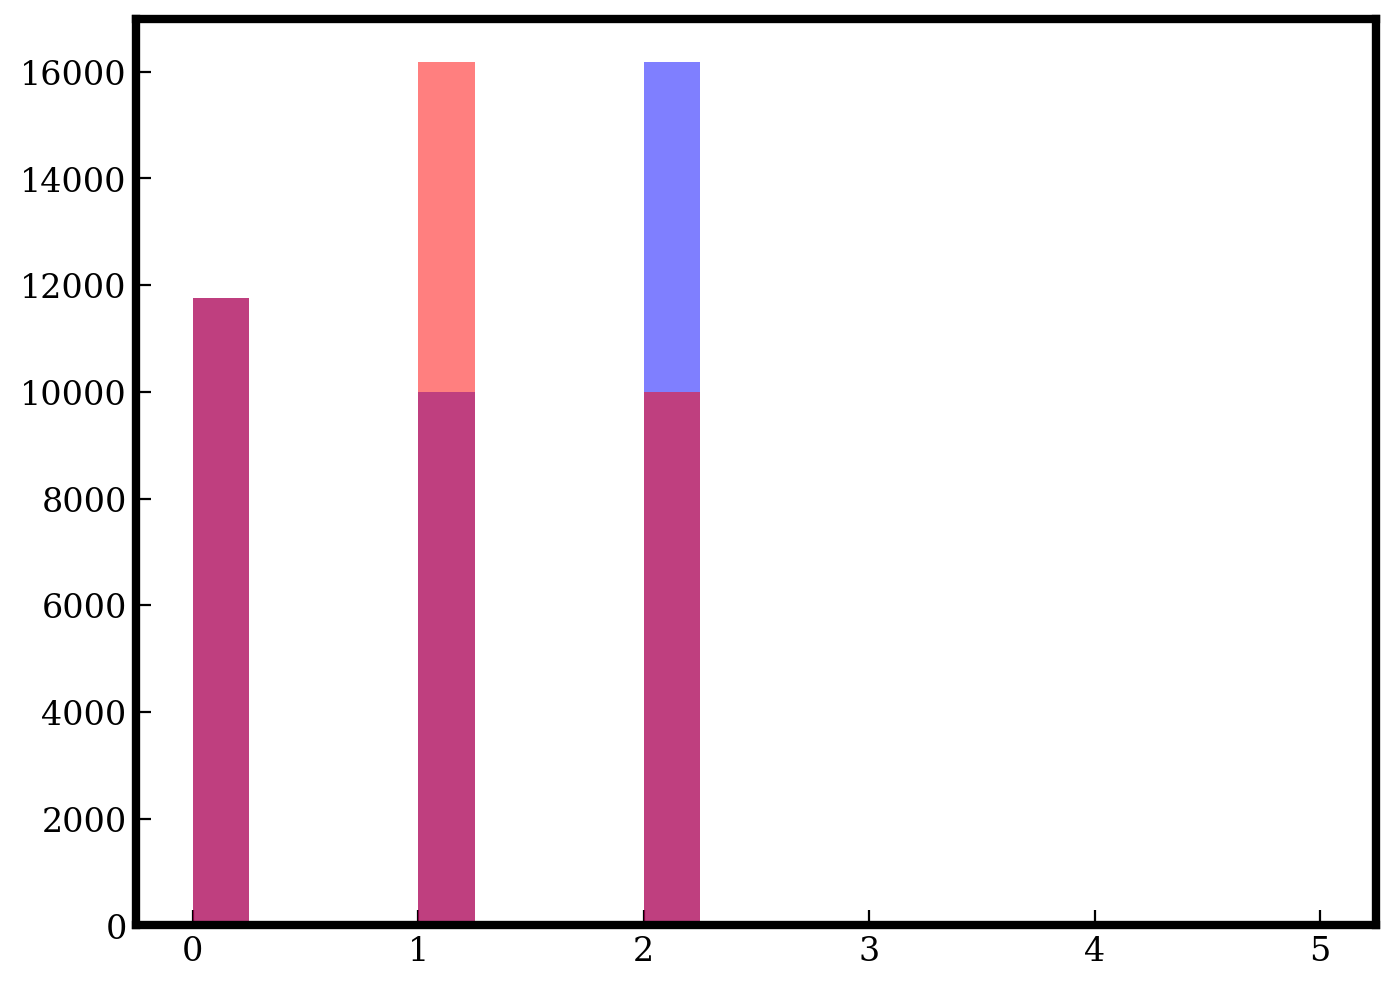

In [9]:
with open("simulatedPlanets/fake_grammaticalSystems_{0}.txt".format(experimentName), "rb") as picklefile:
    systems = pickle.load(picklefile)

data = np.zeros((1,n_planet_features))

for i in range(len(systems)):
    sys = systems[i]
    for j in range(len(sys)):
        data = np.vstack((data,np.array(sys[j])))
        
data = data[1:][idxs]
print(np.shape(data))

bestClass = np.argmax(results,axis=1)
print(bestClass)
print(np.shape(bestClass))


trueClass = np.load("./simulatedPlanets/fake_grammaticalSystems_{0}_truths.npy".format(experimentName))
trueClass = trueClass[idxs]
print(np.shape(trueClass))
print(trueClass)

#note ---the bars don't line up in this histogram because the class labels are out of order!
fig = plt.figure(figsize=(8,6))
plt.hist(bestClass,bins=20,range=(0,5),color='b',alpha=0.5)
plt.hist(trueClass,bins=20,range=(0,5),color='r',alpha=0.5)
plt.show()

In [21]:
#labels = [r'$T_{eff}$',r'$\log{g}$',r'[Fe/H]',r'$R_p/R_*$',r'P']
#limits = [(3000,8000),(3.0,5.5),(-1.25,0.6),(0.0,0.3),(0,600)]
#scaledLimits = [(-4,4),(-4.5,2),(-4,2.5),(-2,2.5),(-0.1,4.)]

#labels = [r'$R_p/R_*$',r'P']
#scaledLimits = [(-2,2.5),(-0.1,4.)]

labels = [r'$R_p\ [R_\odot]$',r'P [days]']
#scaledLimits = [(-3.5,2.5),(-2,2)]
scaledLimits = [(0.0,0.15),(0.,505.)]
#labels = [r'$R_p$']
#scaledLimits = [(-2.5,2.5)]

In [22]:
unscaledData = copy.deepcopy(data)
unscaledData[:,0] = (unscaledData[:,0]*3.41531066e-02)+5.08794529e-02 #unscale Rp
unscaledData[:,1] = (unscaledData[:,1]*1.44231050e+02)+2.49761201e+02 #unscale P
print(np.shape(unscaledData))
print(np.min(unscaledData[:,0]))
print(np.max(unscaledData[:,0]))
print(np.min(unscaledData[:,1]))
print(np.max(unscaledData[:,1]))

(37932, 2)
0.007814092786305606
0.10225086908522574
0.9766962787600448
500.6293988669703


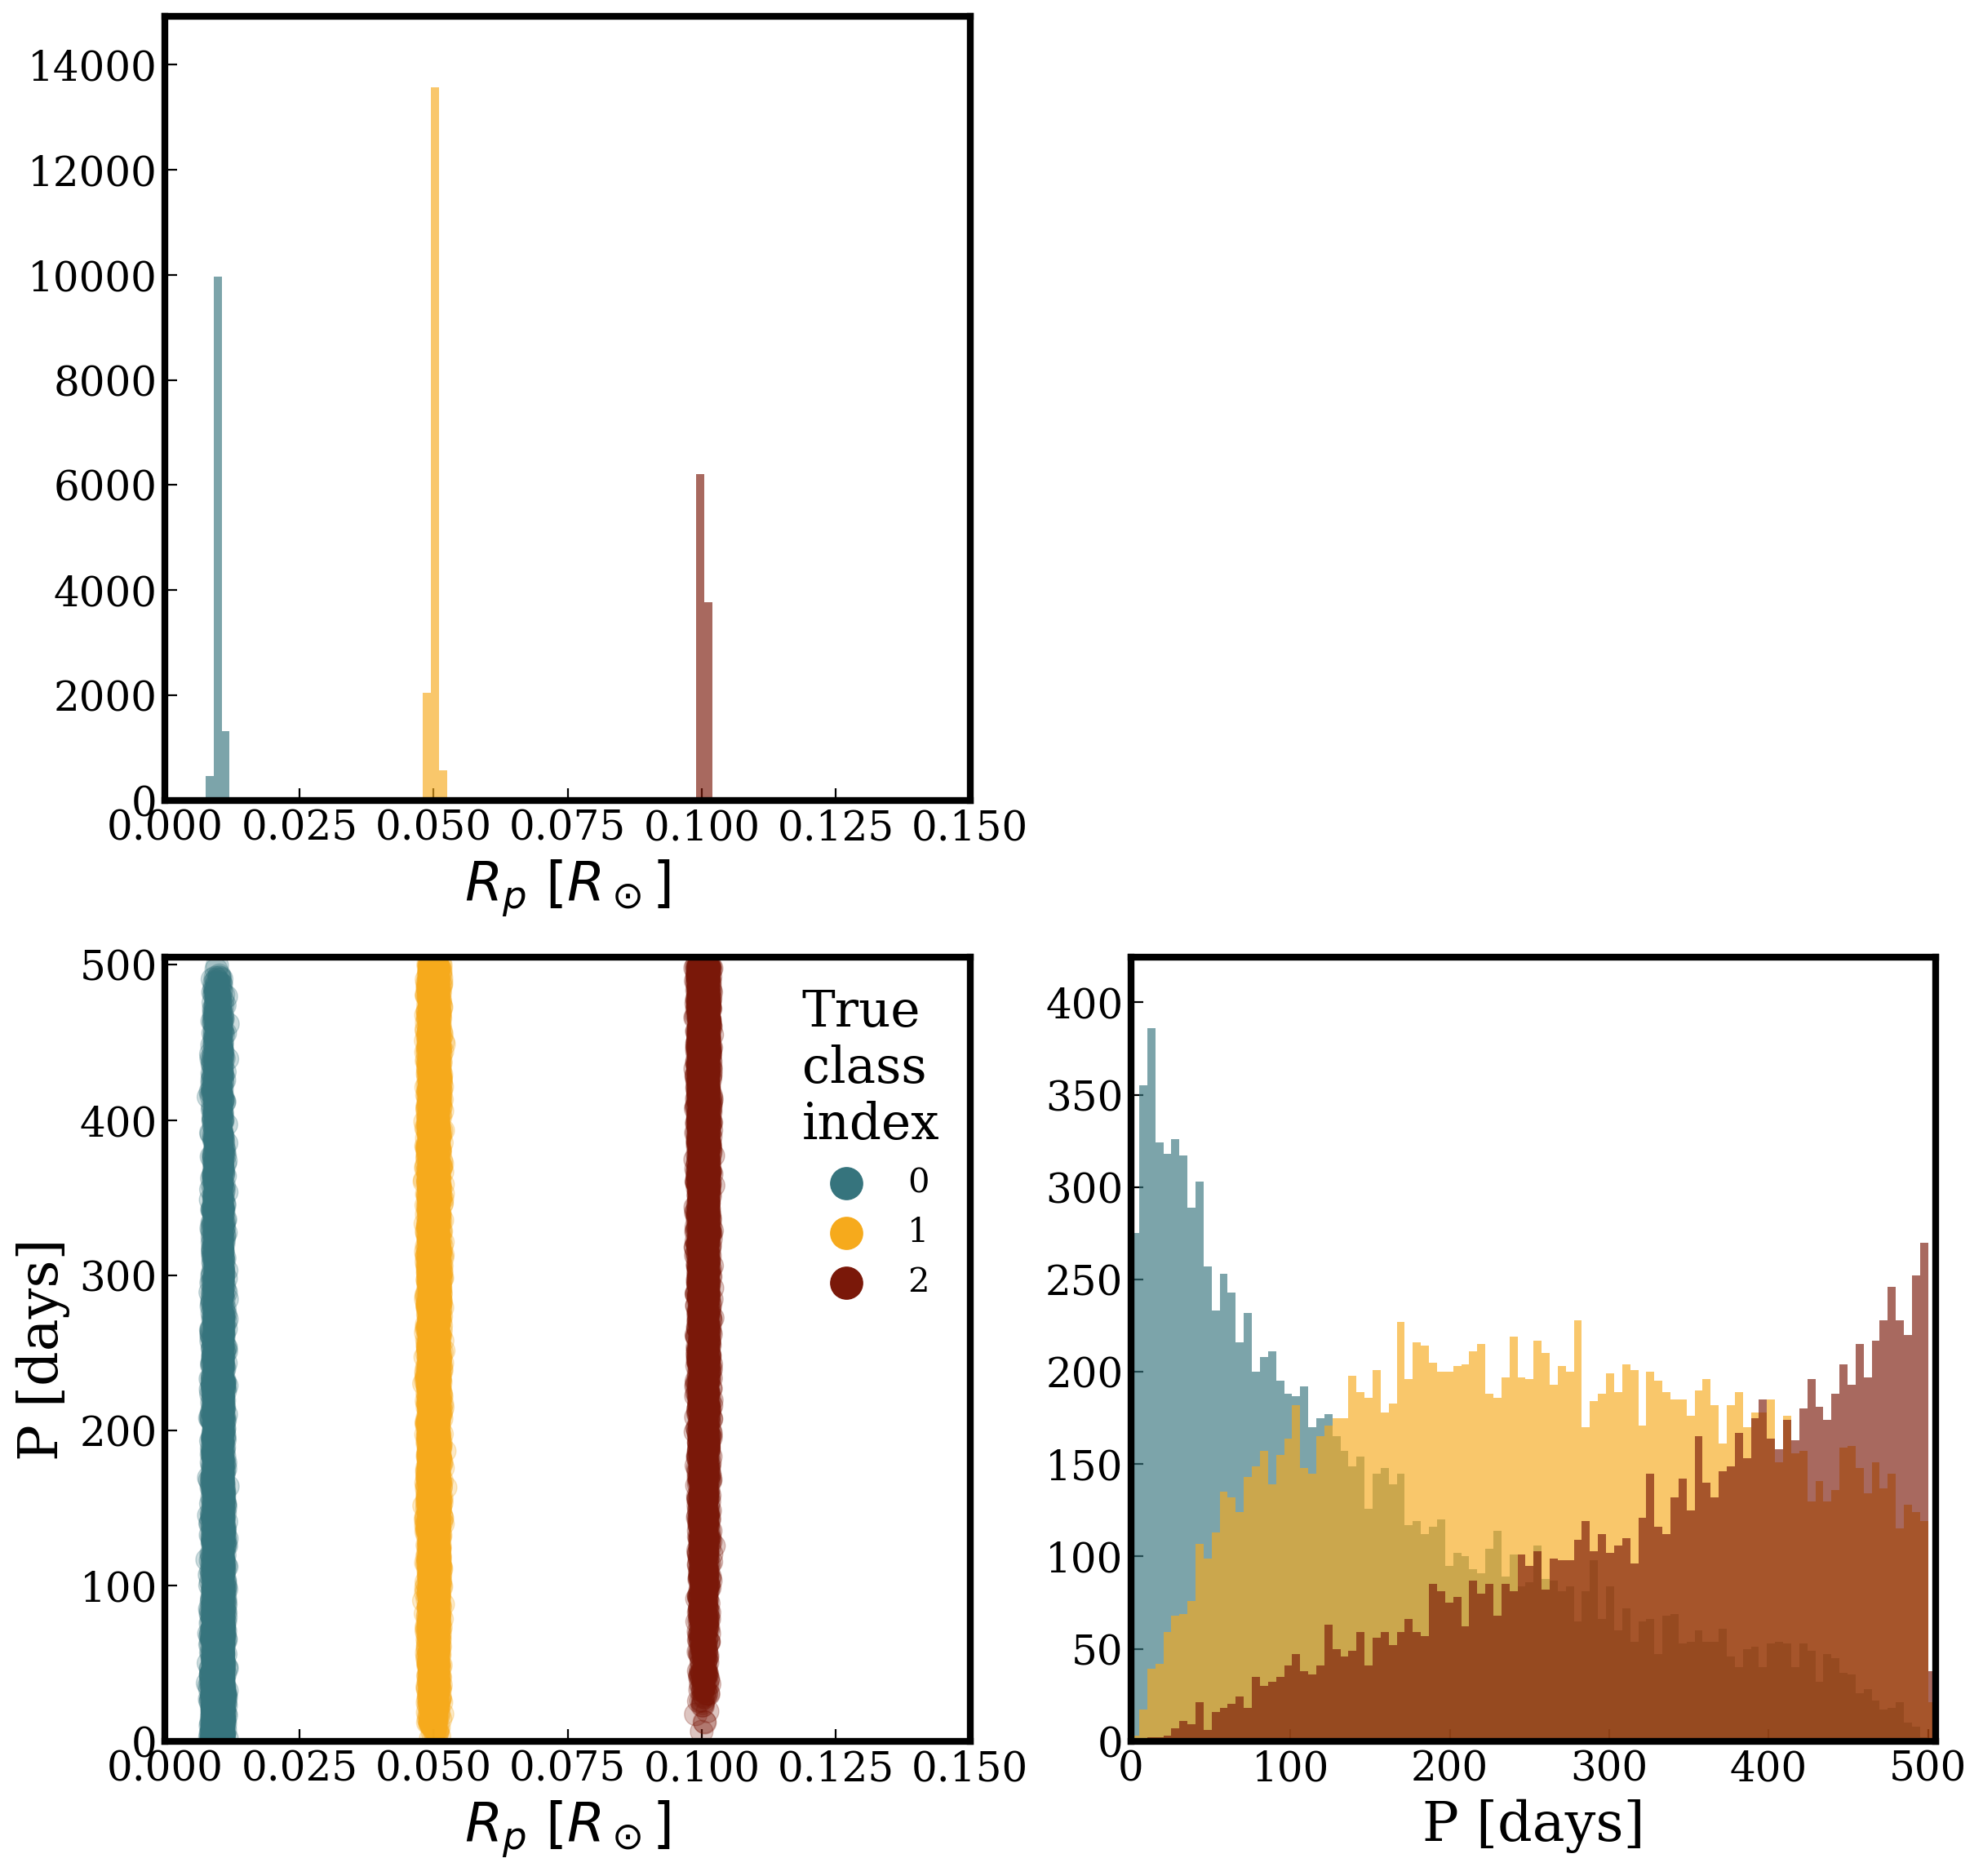

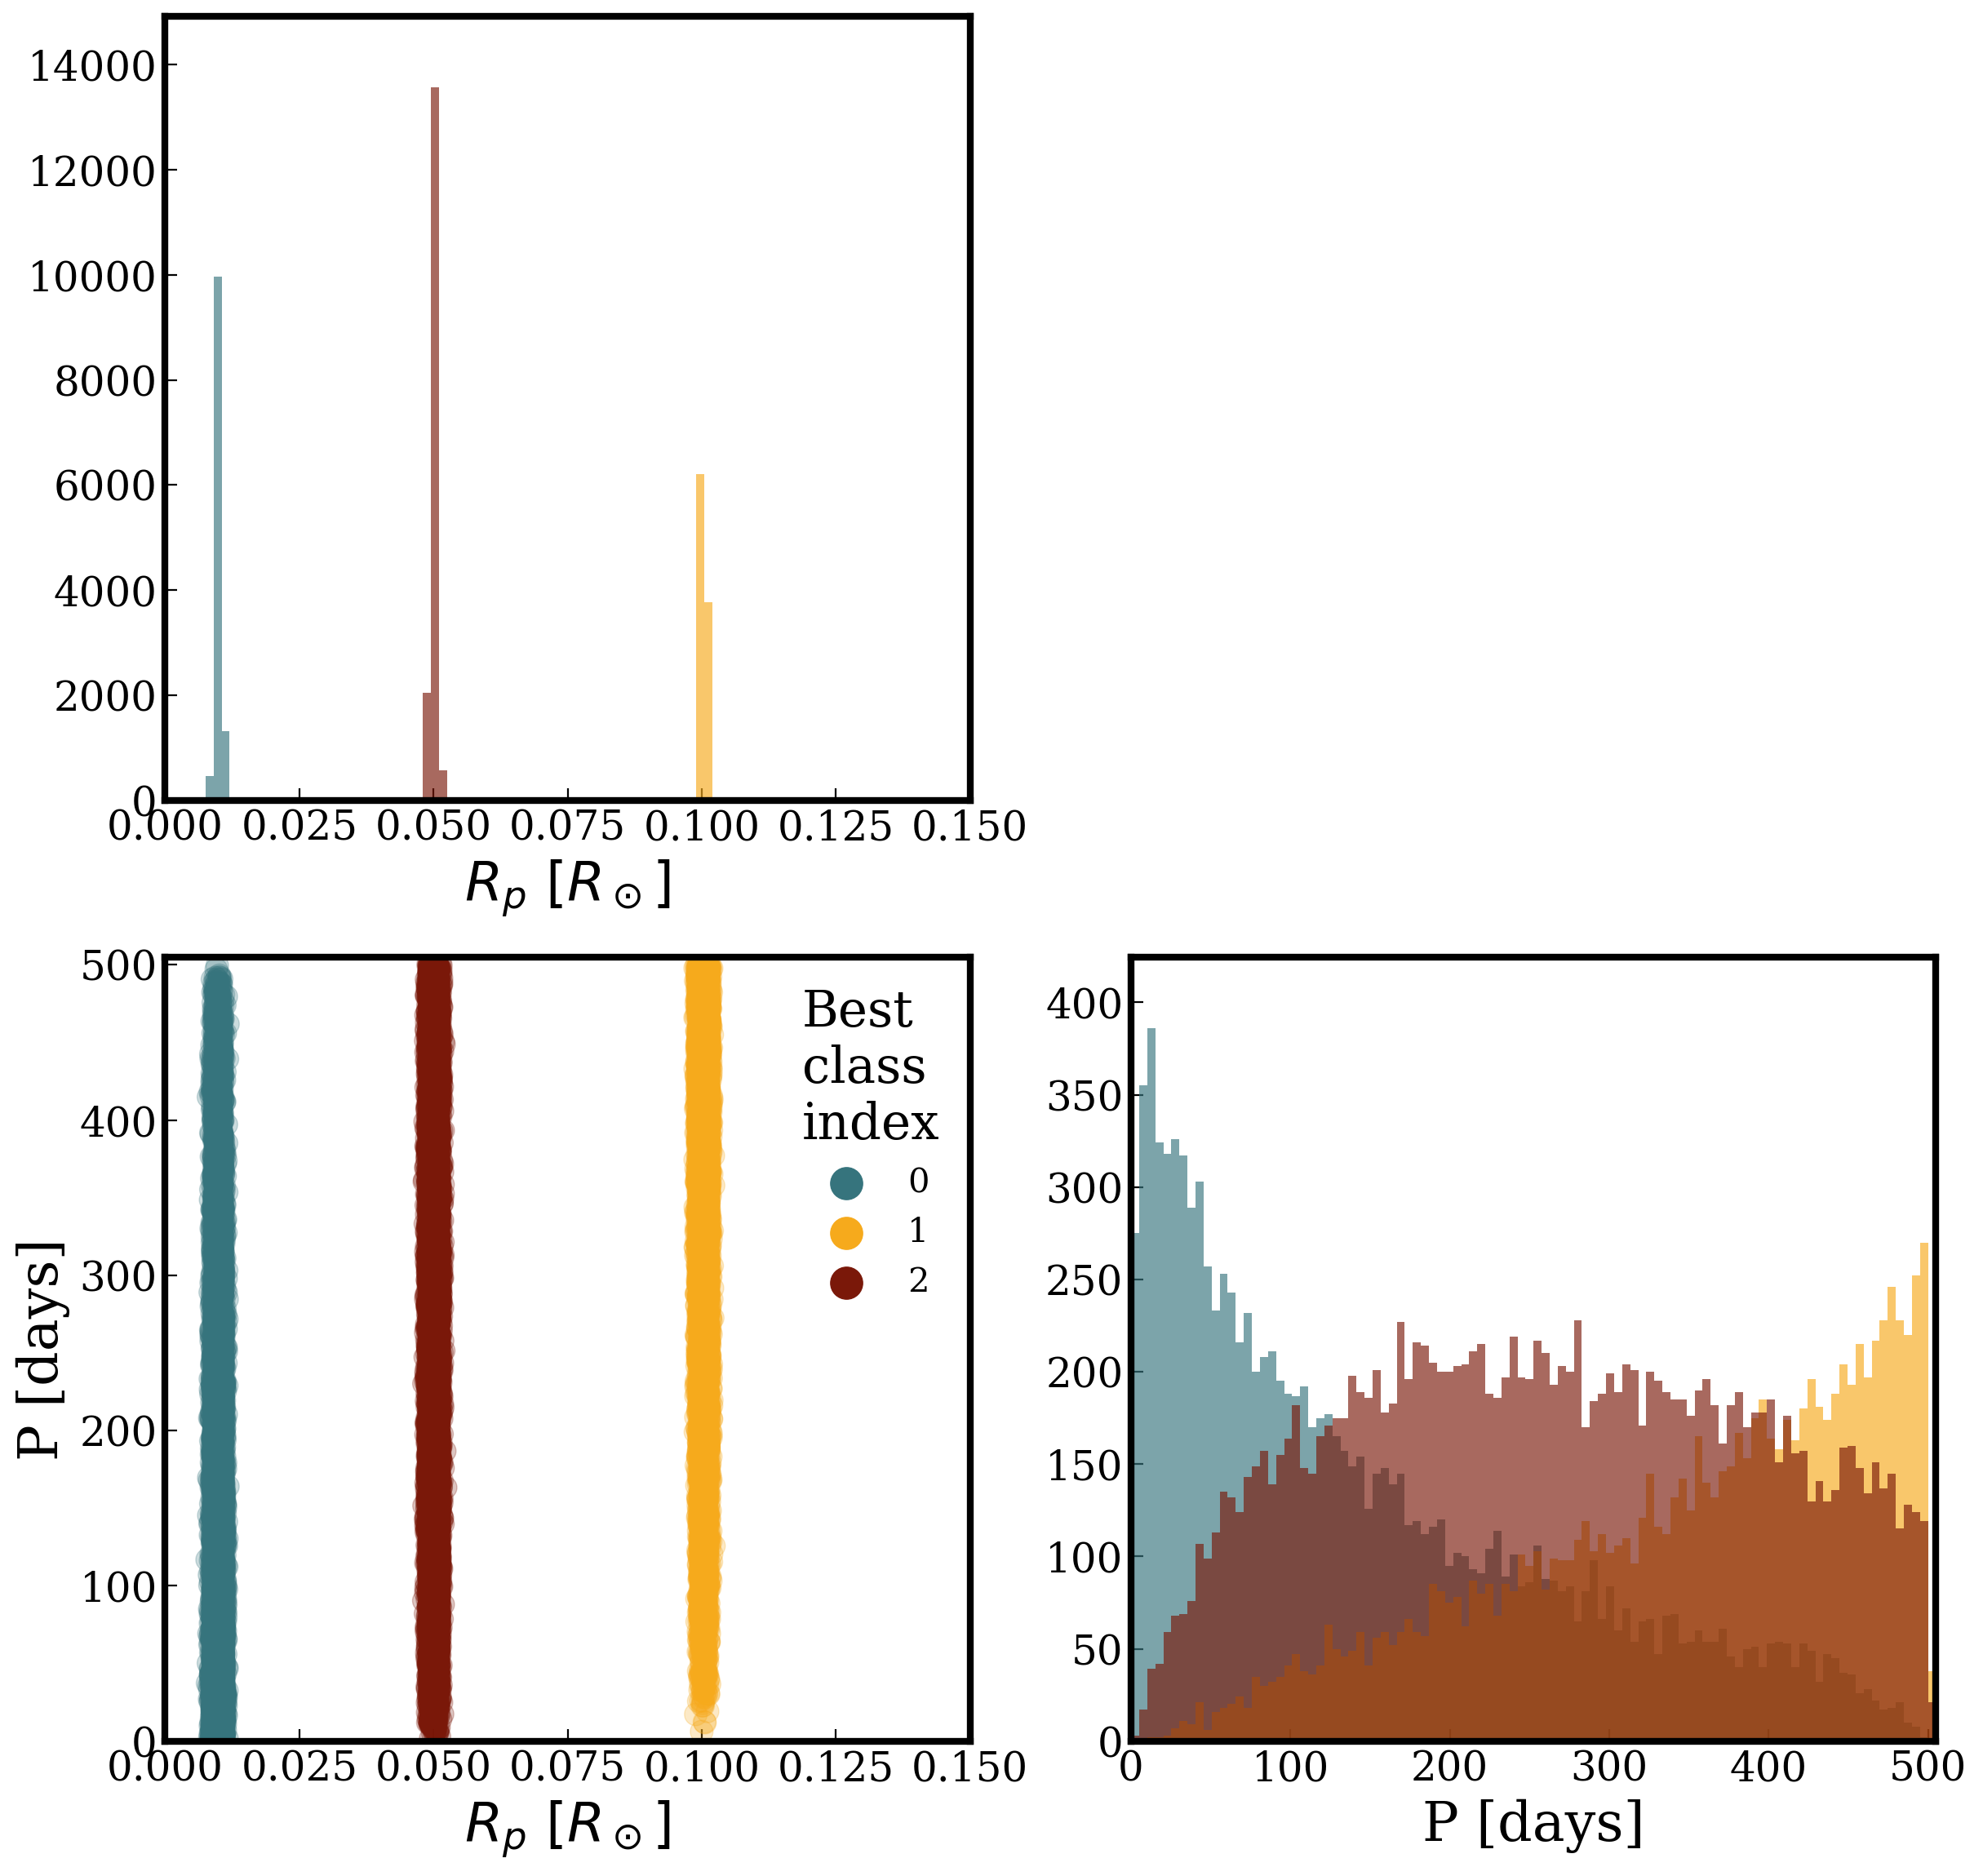

In [24]:
classColoursList = ['#36747D','#F6AA1C','#7A1809','#003049','#BF3E0B','#2E8B57','#EE4266','#540D6E']
#cl = ['#7A1809','#36747D','#F6AA1C']

# TRUTHS and RESULTS
arrays_ = [trueClass, bestClass]
titles_ = ["True","Best"]
plotTitles_ = ["truths","results"]

for h in range(0,2):
    class_colourMaps,class_colours,class_legendColours,class_legendEntries = makePlotColours(arrays_[h],classColoursList)
    #print(data[:,0][0:10])
    #print(data[:,1][0:10])
    #print(class_colours[0:10])
    fig = plt.figure(figsize=(7*n_planet_features,7*n_planet_features))
    gs = gridspec.GridSpec(n_planet_features, n_planet_features)

    for i in range(n_planet_features):
        for j in range(n_planet_features):
            if i>j:
                ax = plt.subplot(gs[i,j])
                makePlot(ax,
                        xdata=unscaledData[:,j],#+arrays_[h]/3.,
                        ydata=unscaledData[:,i],
                        colours=class_colours,
                        xlim=scaledLimits[j],
                        ylim=scaledLimits[i],
                        legendTitle="{0}\nclass\nindex".format(titles_[h]),
                        legendEntries=np.array(class_legendEntries).astype(int),
                        legendColours=class_legendColours,
                        #xscale="log",
                        #yscale="log",
                        xlabel=labels[j],
                        ylabel=labels[i],
                        alpha=0.25)

            if i==j:
                ax = plt.subplot(gs[i,j])
                toHist = []
                nmax = 0
                for k in np.unique(arrays_[h]).astype(int):
                    toHist.append(unscaledData[:,i][arrays_[h]==k])
                    n,bins,patches=ax.hist(unscaledData[:,i][arrays_[h]==k],bins=100,color=class_legendColours[k],range=scaledLimits[i],alpha=0.65)
                    if np.max(n)>nmax:
                        nmax=np.max(n)
                
                #n,bins,patches = ax.hist(toHist,density=True,stacked=True,bins=100,color=class_legendColours,range=scaledLimits[i],alpha=1)
                #nmax = np.max(n)
                ax.set_xlabel(labels[i],fontsize=24)
                ax.tick_params(labelsize=18)
                ax.set_xlim(scaledLimits[i])
                ax.set_ylim(0,nmax*1.1)


    plt.subplots_adjust(wspace=0.2,hspace=0.2)
    #plt.show()
    plt.savefig("./simulatedPlanets/fake_grammaticalSystems_{0}_{1}.png".format(experimentName,plotTitles_[h]),fmt="png")

# Look at POS tagging results

In [9]:
posResults = np.load("../POStagger/example.w_classprobs.npy")
print(posResults)
print(np.argmax(posResults,axis=1))
words = ['chased','chased','chased','cat','the','dog','dog','rat','the','the','cat','the','the','the','rat'] # as encoded in Y1
posTruths = ['V', 'V', 'V', 'N', 'D', 'N', 'N', 'N', 'D', 'D', 'N', 'D', 'D', 'D', 'N']
posTruthIdxs = np.array((0, 0, 0, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1))
print(posTruthIdxs)

# So everything appears to be working fine, except that the ordering in Y1 is not intuitive, and I should double-check
# that it's right in the planet case.

[[0.81817073 0.05507379 0.12675548]
 [0.81817073 0.05507379 0.12675548]
 [0.81817073 0.05507379 0.12675548]
 [0.45893332 0.48625085 0.05481588]
 [0.03423147 0.04163561 0.92413294]
 [0.18549669 0.78633541 0.02816791]
 [0.18549669 0.78633541 0.02816791]
 [0.32601541 0.61282152 0.06116307]
 [0.03423147 0.04163561 0.92413294]
 [0.03423147 0.04163561 0.92413294]
 [0.45893332 0.48625085 0.05481588]
 [0.03423147 0.04163561 0.92413294]
 [0.03423147 0.04163561 0.92413294]
 [0.03423147 0.04163561 0.92413294]
 [0.32601544 0.61282146 0.06116306]]
[0 0 0 1 2 1 1 1 2 2 1 2 2 2 1]
[0 0 0 1 2 1 1 1 2 2 1 2 2 2 1]


## What about when I make sentences like: "dog dog dog dog", "chased chased chased", "the the the the the the". Does it work?

In [39]:
# Yes!! Although something about indexing is a little weird...
posSameResults = np.load("../POStagger/exampleSame.w_classprobs.npy")
posSameIdxs = np.load("../POStagger/exampleSame.w_idxs.npy")
posSameIdxs[posSameIdxs==3] = 0
posSameIdxs[posSameIdxs==2] = 4
posSameIdxs[posSameIdxs==1] = 2
posSameIdxs[posSameIdxs==4] = 1

print(posSameIdxs)
print(np.argmax(posSameResults,axis=1))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 1 2 2 1 2 1 1 2 1 2 1 1 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 1 2 2 1 2 1 1 2 1 2 1 1 2]


In [82]:
test = np.zeros((1000,3))
print(np.shape(np.mean(test,axis=0)))

(3,)
